In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from preprocessing import *
from postprocessing import *
from cnn_models import *
from datetime import datetime
from evaluate import *

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Overview
The goal here is to use the CNN to reduce the size of the input image to obtain a "discretized" image of shape, e.g. (W/16, H/16). Every entry of this image is related to a patch in the input image. This obtained image is compared by the CNN with the groundtruth (after properly discretizing by it patch-wise).

### - Load data

In [19]:
# Loaded a set of images
n = 100

imgs, gt_imgs = load_images(n)
imgs[0].shape, gt_imgs[0].shape

Loading 100 images


((400, 400, 3), (400, 400))

In [3]:
X = imgs
Y = gt_imgs
set_ = SimpleNamespace()
set_.X = X
set_.Y = Y

In [48]:
import scipy
pixels = gt_imgs.flatten()
roads_mask = pixels>0.25
pixels = pixels*0
pixels[roads_mask] = 1
np.sum(pixels==1)/pixels.shape[0]

0.20474031249999999

In [ ]:
# for i in range(100):
i = 41
display_prediction(set_.X[i], set_.Y[i])
plt
# plt.show()
# plt.savefig("highway.png")

### - Reshape the data NOMORE (we pass the train directly the images as they are so not to mess data augmentation)
We reshape each input to fulfill our cnn inputs and output shape.

In [ ]:
# # !!! set predict_patch_width in accordance to the model you are using !!!
# # the shape of the output of the model depends on the strides parameters 
# # (if a layer has stride=2 then each ouput's side is half of the input'side).
# # predict_patch_width must be equal to the total reduction of the model, e.g.
# # if the model has three layer with stride=2 => the input of the model is 
# # reduced by a factor of 2*2*2=8, i.e. the ouptut will be patch-wise with 
# # patches 8x8 pixels.
# predict_patch_width = 8

# X, Y = images_to_XY(imgs, gt_imgs, predict_patch_width=predict_patch_width)

# set_ = SimpleNamespace()
# set_.X = X
# set_.Y = Y

# X.shape, Y.shape

In [ ]:
# vvv checking data augmentation
# gen = batches_generator(imgs, gt_imgs)
# batches_x = []
# batches_y = []
# for i in range(4):
#     x_batch, y_batch = next(gen)
#     batches_x.append(x_batch)
#     batches_y.append(y_batch)
# batches_x = np.array(batches_x)
# batches_y = np.array(batches_y)

# # batches_x = np.expand_dims(batches_x, axis=0)
# # batches_y = np.expand_dims(batches_y, axis=0)
# batches_x.shape, batches_y.shape

In [ ]:
# # batch = 0
# fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# img = imgs[0]
# gt_img = gt_imgs[0]
# new_img = make_img_overlay(img, gt_img)   
# axs[0][0].imshow(new_img)

# batch, im = 1, 0
# img = batches_x[batch, im, :, :]
# gt_img = batches_y[batch, im, :, :, 1]
# h, w = img.shape[0], img.shape[1]
# gt_img = predictions_to_img(gt_img, (h, w))
# new_img = make_img_overlay(img, gt_img)   
# axs[0][1].imshow(new_img)

# batch, im = 1, 1
# img = batches_x[batch, im, :, :]
# gt_img = batches_y[batch, im, :, :, 1]
# h, w = img.shape[0], img.shape[1]
# gt_img = predictions_to_img(gt_img, (h, w))
# new_img = make_img_overlay(img, gt_img)   
# axs[1][0].imshow(new_img)

# batch, im = 1, 2
# img = batches_x[batch, im, :, :]
# gt_img = batches_y[batch, im, :, :, 1]
# h, w = img.shape[0], img.shape[1]
# gt_img = predictions_to_img(gt_img, (h, w))
# new_img = make_img_overlay(img, gt_img)   
# axs[1][1].imshow(new_img)

# plt.tight_layout()
# plt.savefig("data_augmentation.png")

### - For now avoid cross validation, just split the datasest in test and train. 

In [ ]:
test_ratio = 0.25

train, test = split_train_test(X, Y, test_ratio=test_ratio, seed=1)
train.X.shape, train.Y.shape, test.X.shape, test.Y.shape 

In [ ]:
# # check it makes sense (show the i-th input of set_)
# i = 0
# set_ = test

# fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].imshow(set_.Y[i, :, :, 1], cmap='gray')
# axs[1].imshow(set_.X[i, :, :])

### - Build the CNN model or load a previous one

- Choose one of the models you defined (with model_n) and initialize it.

In [ ]:
# generate an unique name for the model (so to avoid overwriting previous models)
folder_name = "model_"+str('{0:%Y-%m-%d_%H:%M:%S}'.format(datetime.now()))
model_path = "models/"+folder_name
model = CnnModel(model_n=9, model_path=model_path)
model.summary()

- Otherwise load a previous model

In [41]:
# give the folder
folder_name = "model_2017-12-17_130123"
model_path = "../models/"+folder_name
models = []
models_id = [7]
for i in range(len(models_id)):
    models.append(CnnModel(model_n=models_id[i], model_path=model_path))
    models[i].load() # load the model and its weights
    models[i].summary()
model = models[0]

Loaded model from disk
model_leakyrelu_maxpooling
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, None, None, 48)    17472     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, None, None, 48)    0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 48)    0         
_________________________________________________________________
dropout_5 (Dropout)          (None, None, None, 48)    0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 64)    150592    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, None, None, 64)    0         
_________________________________________________________________
max_pooling2d_5 (MaxPoolin

In [55]:
model.load_weights("2017-12-17_140431_best-weightsmodel_leakyrelu_maxpooling.hdf5")

### - Train the model on the train data while validating it on the test data

In [ ]:
# pass a batch size which is a factor of train.shape[0] so that all the batches are fo the same size
num_epochs=1
batch_size=5
_ = model.train(train, test=test, num_epochs=num_epochs, batch_size=batch_size, monitor='val_loss') 

### - Run cross validation to evaluate the model

In [ ]:
result = model.cross_validation(set_, batch_size=batch_size, num_epochs=num_epochs)
result

In [ ]:
# plot the histories of the cross validation
plot_history(result["history_mean"]) 
# history of the folds (check if there is a worst case)
# plot_history(result["histories"][0]) 
# plot_history(result["histories"][1]) 
# plot_history(result["histories"][2]) 
# plot_history(result["histories"][3]) 

#### Plot the accuracy and the loss obtained during training

model_leakyrelu_maxpooling


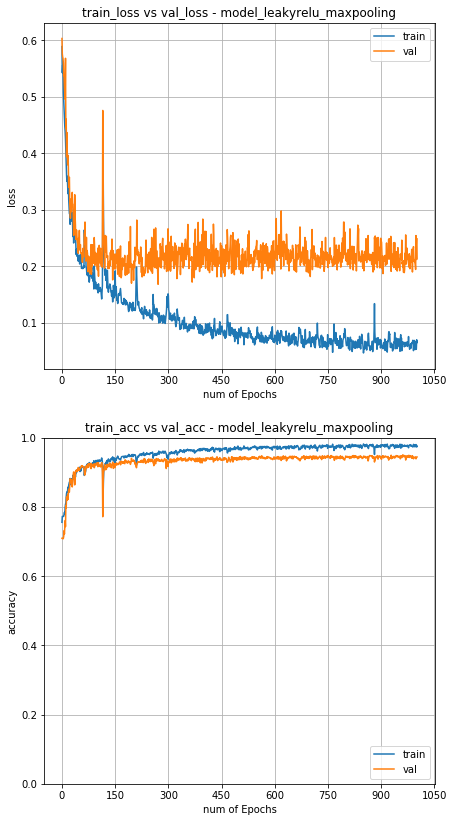

In [6]:
last_epochs=-1 # plot only the last n epochs
for model in models:
    print(model.name())
    model.plot_history(last_epochs=last_epochs)
    plt.show()

#### Display the output of a specific layer

In [ ]:
# these are all the layers 
model.model.layers

In [ ]:
# choose a layer and an image 
image = set_.X[0]
layer_num = 1

model.show_layer_output(image, layer_num, filename="") # pass a filename if you want to store the image to file 

### - Evaluate the model on the test data

model_leakyrelu_maxpooling
                precision    recall  f1-score   support

0 (background)       0.95      0.98      0.97    173915
      1 (road)       0.92      0.84      0.88     51085

   avg / total       0.95      0.95      0.95    225000

Confusion matrix, without normalization


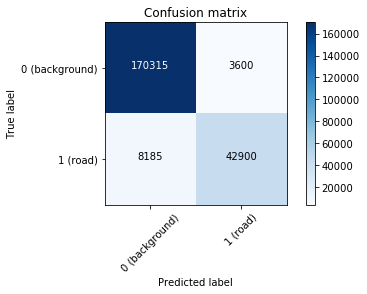

Normalized confusion matrix


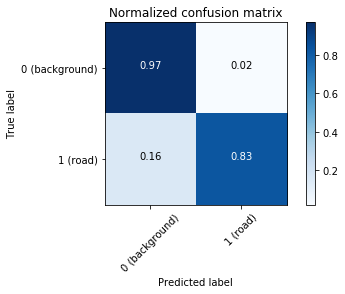

In [58]:
# check the performance on train or test
set_ = set_
i = 10
asd = SimpleNamespace()
asd.X = set_.X[i:]
asd.Y = set_.Y[i:]
for model in models:
    print(model.name())
    model.evaluate_model(asd.X, asd.Y)
    plt.show()

### - Show a prediction

In [ ]:
# choose an image to predict (or part of it)
img = test.X[0][:, :]

models[1].display_prediction(img, ax=None)

### - Save/load model

In [ ]:
model.save()

## - Postprocessing

#### 1. Predict an image after rotating and flipping in some predefined ways and then average the predictions. 

- **predict**

In [11]:
set_.X.shape, set_.Y.shape

((100, 400, 400, 3), (100, 400, 400))

Normal prediction

In [12]:
pred_norm = model.predict(set_.X)
pred_norm.shape

(100, 50, 50, 2)

Predict augmenting the image: 4 rotations

In [ ]:
pred_rot4 = model.predict_augmented(set_.X, n_rotations=4)
pred_rot4.shape

Predict augmenting the image: 8 rotations

In [ ]:
pred_rot8 = model.predict_augmented(set_.X, n_rotations=8)
pred_rot8.shape

- ** evaluate **

Evaluate all of them and compare the F1 scores

In [25]:
true = predictions_to_class(np.array([gt_img_to_Y(y, predict_patch_width=8) for y in set_.Y])).flatten()
pred_norm_class = predictions_to_class(pred_norm).flatten()
pred_rot4_class = predictions_to_class(pred_rot4).flatten()
pred_rot8_class = predictions_to_class(pred_rot8).flatten()
pred_norm_class.shape, pred_rot4_class.shape, pred_rot8_class.shape, true.shape

((250000,), (250000,), (250000,), (250000,))

                precision    recall  f1-score   support

0 (background)       1.00      0.99      0.99    192521
      1 (road)       0.98      0.98      0.98     57479

   avg / total       0.99      0.99      0.99    250000

Confusion matrix, without normalization


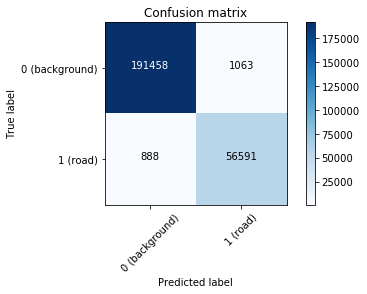

Normalized confusion matrix


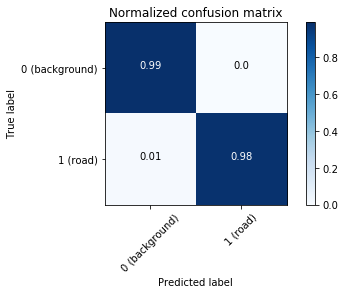

In [40]:
evaluate_predictions(pred_norm_class, true)

In [ ]:
evaluate_predictions(pred_rot4_class, true)

In [ ]:
evaluate_predictions(pred_rot8_class, true)

In [ ]:
# im_rot = rotate(im, 45, reshape=True, order=1, mode="reflect")
# plt.figure(figsize=(10, 10))
# plt.imshow(im_rot)
# plt.show()

# pred = model.predict(np.array([im_rot]))[0]
# pred = take_image_at_center(rotate_image(pred, -45), target_shape=(50, 50))
# plt.figure(figsize=(10, 10))
# plt.imshow(prediction_to_class(pred), cmap="gray")
# plt.show()

- Choose the best threshold to classify a patch as road.

In [29]:
grid_search_treshold(pred_norm[:, :, :, 1].flatten(), true)

(0.98309300586178705, 0.53000000000000003)

In [30]:
grid_search_treshold(pred_rot4[:, :, :, 1].flatten(), true)

(0.98871375076199608, 0.54000000000000004)

In [31]:
grid_search_treshold(pred_rot8[:, :, :, 1].flatten(), true)

(0.97797379776178361, 0.47000000000000003)

In [43]:
model.predict_augmented_and_export()

Threshold: 0.55
Loading 5 images to predict
loading image ../dataset/test_set_images/test_1/test_1.png
loading image ../dataset/test_set_images/test_2/test_2.png
loading image ../dataset/test_set_images/test_3/test_3.png
loading image ../dataset/test_set_images/test_4/test_4.png
loading image ../dataset/test_set_images/test_5/test_5.png
Predicting image 0
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
Predicting image 1
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rot

/home/niccolo/anaconda3/envs/ada/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


Loading 5 images to predict
loading image ../dataset/test_set_images/test_6/test_6.png
loading image ../dataset/test_set_images/test_7/test_7.png
loading image ../dataset/test_set_images/test_8/test_8.png
loading image ../dataset/test_set_images/test_9/test_9.png
loading image ../dataset/test_set_images/test_10/test_10.png
Predicting image 0
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
Predicting image 1
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 deg

		Rotate by 270 degrees and predict
Loading 5 images to predict
loading image ../dataset/test_set_images/test_26/test_26.png
loading image ../dataset/test_set_images/test_27/test_27.png
loading image ../dataset/test_set_images/test_28/test_28.png
loading image ../dataset/test_set_images/test_29/test_29.png
loading image ../dataset/test_set_images/test_30/test_30.png
Predicting image 0
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
Predicting image 1
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by

		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
Loading 5 images to predict
loading image ../dataset/test_set_images/test_46/test_46.png
loading image ../dataset/test_set_images/test_47/test_47.png
loading image ../dataset/test_set_images/test_48/test_48.png
loading image ../dataset/test_set_images/test_49/test_49.png
loading image ../dataset/test_set_images/test_50/test_50.png
Predicting image 0
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
Predicting image 1
	Flipping image: False
		Rotate by 0 degrees and predict
		Rotate by 90 degrees and predict
		Rotate by 180 degrees and predict
		Rotate by 270 degrees and predict
	Flipping image: True
		Rotate by 0 degrees and predict
		Rotate b

### - Others

In [ ]:
# some callbacks example: 

# create a list of callbacks we want to use during training
# # a callback to store epoch results to a csv file
# filename='model_train_new.csv'
# csv_log = callbacks.CSVLogger(filename, separator=',', append=False)

# # a callback to stob before doing the predefined number of epochs (stop before overfitting the data)
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

# # a callback to save the best model (best model = the one with the lowest 'monitor' variable)
# filepath = "best-weights-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"
# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # callbacks_list = [csv_log,early_stopping,checkpoint]

print(
    "-get configurations:", "\n",
    model.get_config(), "\n",
    model.layers[0].get_config(), "\n",

    "\n-get shapes", "\n",
    model.layers[0].input_shape, "\n",
    model.layers[0].output_shape, "\n",
    
    "\n-get weights", "\n",
    model.layers[0].get_weights()[0].shape, "\n",
    
    "\n-check if trainable", "\n",
    model.layers[0].trainable, "\n", # you can set this to false to "freeze" a layer
)

In [ ]:
from IPython.core.debugger import Pdb
debugger = Pdb()
debugger.set_trace() # put this line as a breakpoint

Test batch generation

In [ ]:
gen1, gen2 = image_generators(X, Y) 

In [ ]:
from cnn_models import batches_generator
j = 0
x_batches = []
y_batches = []

for x, y in batches_generator(X[:4], Y[:4], batch_size = 4):
    j += 1
    if j > 10:
        break
    x_batches.append(x)
    y_batches.append(y)

In [ ]:
np.array(x_batches).shape, np.array(y_batches).shape

In [ ]:
b = 0
i = -1

In [ ]:
i += 1
if i >= x_batches[0].shape[0]:
    i = 0
    b += 1
print("Batch", str(b) + ". Image", i)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((20, 10))
axs[0].imshow(x_batches[b][i], cmap='gray')
axs[1].imshow(y_batches[b][i][:, :, 1], cmap='gray')

Test set predictions probabilities

In [11]:
images = load_images_to_predict(0,50)
images.shape

Loading 50 images to predict
loading image ../dataset/test_set_images/test_1/test_1.png
loading image ../dataset/test_set_images/test_2/test_2.png
loading image ../dataset/test_set_images/test_3/test_3.png
loading image ../dataset/test_set_images/test_4/test_4.png
loading image ../dataset/test_set_images/test_5/test_5.png
loading image ../dataset/test_set_images/test_6/test_6.png
loading image ../dataset/test_set_images/test_7/test_7.png
loading image ../dataset/test_set_images/test_8/test_8.png
loading image ../dataset/test_set_images/test_9/test_9.png
loading image ../dataset/test_set_images/test_10/test_10.png
loading image ../dataset/test_set_images/test_11/test_11.png
loading image ../dataset/test_set_images/test_12/test_12.png
loading image ../dataset/test_set_images/test_13/test_13.png
loading image ../dataset/test_set_images/test_14/test_14.png
loading image ../dataset/test_set_images/test_15/test_15.png
loading image ../dataset/test_set_images/test_16/test_16.png
loading image

(50, 608, 608, 3)

In [59]:
predictions = model.model.predict(imgs)
predictions.shape

(100, 50, 50, 2)

In [60]:
np.save("predictions.npy",predictions)

In [47]:
asd = np.load("predictions.npy")

In [48]:
np.sum(predictions != asd)

0

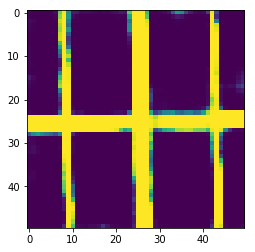

In [49]:
plt.imshow(predictions[0, :, :, 1])